In [2]:
import os, glob, math, time, json, random
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [3]:
root = "/projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input"
ravdess = os.path.join(root, "ravdess-emotional-speech-audio", "audio_speech_actors_01-24")
cremad  = os.path.join(root, "cremad", "AudioWAV")
tess    = os.path.join(root, "toronto-emotional-speech-set-tess", "tess toronto emotional speech set data", "TESS Toronto emotional speech set data")
savee   = os.path.join(root, "surrey-audiovisual-expressed-emotion-savee", "ALL")

In [ ]:
def list_wavs(root_dir):
    return sorted(glob.glob(os.path.join(root_dir, "**", "*.wav"), recursive=True))

def process_ravdess(root_dir):
    id2emo = {
        "01":"neutral","02":"neutral","03":"happy","04":"sad",
        "05":"angry","06":"fear","07":"disgust","08":"surprise"
    }
    rows = []
    for p in list_wavs(root_dir):
        parts = Path(p).stem.split("-")
        if len(parts) == 7 and parts[2] in id2emo:
            rows.append({
                "Path": p,
                "dataset": "RAVDESS",
                "emotion": id2emo[parts[2]],
                "intensity": parts[3],
                "statement": parts[4],
                "repetition": parts[5],
                "actor": parts[6]
            })
    return pd.DataFrame(rows)

def process_cremad(root_dir):
    map3 = {"SAD":"sad","ANG":"angry","DIS":"disgust","FEA":"fear","HAP":"happy","NEU":"neutral"}
    rows = []
    for p in list_wavs(root_dir):
        parts = Path(p).stem.split("_")
        if len(parts) >= 4 and parts[2] in map3:
            rows.append({
                "Path": p,
                "dataset": "CREMA-D",
                "emotion": map3[parts[2]],
                "intensity": parts[3],   # LO/HI
                "statement": None,
                "repetition": None,
                "actor": parts[0]
            })
    return pd.DataFrame(rows)

def process_tess(root_dir):
    rows = []
    for p in list_wavs(root_dir):
        parts = Path(p).stem.split("_")
        if len(parts) >= 2:
            emo = parts[1]
            emo = "surprise" if emo == "ps" else emo
            rows.append({
                "Path": p,
                "dataset": "TESS",
                "emotion": emo,
                "intensity": None,
                "statement": None,
                "repetition": parts[2] if len(parts) == 3 else None,
                "actor": parts[0]   # OAF / YAF
            })
    return pd.DataFrame(rows)

def process_savee(root_dir):
    tag2emo = {"a":"angry","d":"disgust","f":"fear","h":"happy","n":"neutral","sa":"sad","su":"surprise"}
    rows = []
    for p in list_wavs(root_dir):
        name = Path(p).stem
        parts = name.split("_")
        if len(parts) >= 2:
            actor = parts[0]
            tag = parts[1]
            key = "sa" if tag.startswith("sa") else ("su" if tag.startswith("su") else tag[0])
            if key in tag2emo:
                rows.append({
                    "Path": p,
                    "dataset": "SAVEE",
                    "emotion": tag2emo[key],
                    "intensity": None,
                    "statement": None,
                    "repetition": tag[2:] if len(tag) > 1 else None,
                    "actor": actor
                })
    return pd.DataFrame(rows)

dfs = [
    process_ravdess(ravdess),
    process_cremad(cremad),
    process_tess(tess),
    process_savee(savee)
]

df = pd.concat(dfs, ignore_index=True)
print("Total samples:", len(df))


Total samples: 16402


,Path,dataset,emotion,intensity,statement,repetition,actor
0,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,RAVDESS,neutral,01,01,01,01
1,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,RAVDESS,neutral,01,01,02,01
2,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,RAVDESS,neutral,01,02,01,01
3,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,RAVDESS,neutral,01,02,02,01
4,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,RAVDESS,neutral,01,01,01,01


In [32]:
df.columns
df.head()

,Path,dataset,emotion,intensity,statement,repetition,actor,emotion_label
0,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,RAVDESS,neutral,01,01,01,01,neutral
1,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,RAVDESS,neutral,01,01,02,01,neutral
2,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,RAVDESS,neutral,01,02,01,01,neutral
3,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,RAVDESS,neutral,01,02,02,01,neutral
4,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,RAVDESS,neutral,01,01,01,01,neutral


In [33]:
emotion_labels = {
    "neutral": "neutral",
    "happy": "happy",
    "sad": "sad",
    "angry": "angry",
    "fear": "fear",
    "disgust": "disgust",
    "surprise": "surprise"
}

df["emotion_label"] = df["emotion"].map(emotion_labels)
#based on code here: https://zenodo.org/records/1188976


In [34]:
print("Unique values in 'emotion':", df['emotion'].unique())
print("Unique values in 'emotion_label':", df['emotion_label'].unique())

Unique values in 'emotion': ['neutral' 'happy' 'sad' 'angry' 'fear' 'disgust' 'surprise']
Unique values in 'emotion_label': ['neutral' 'happy' 'sad' 'angry' 'fear' 'disgust' 'surprise']


In [30]:
print("no. of unique actors:", df["actor"].nunique())
print("no. emotions:", df["emotion_label"].unique())

no. of unique actors: 119
no. emotions: ['neutral' 'happy' 'sad' 'angry' 'fear' 'disgust' 'surprise']


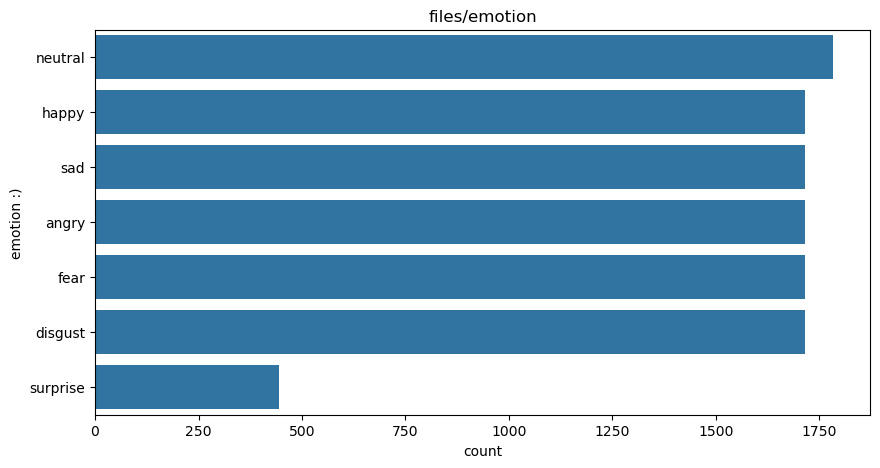

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(y="emotion_label", data=df, order=df["emotion_label"].value_counts().index)
plt.title("files/emotion")
plt.xlabel("count")
plt.ylabel("emotion :)")
plt.show()

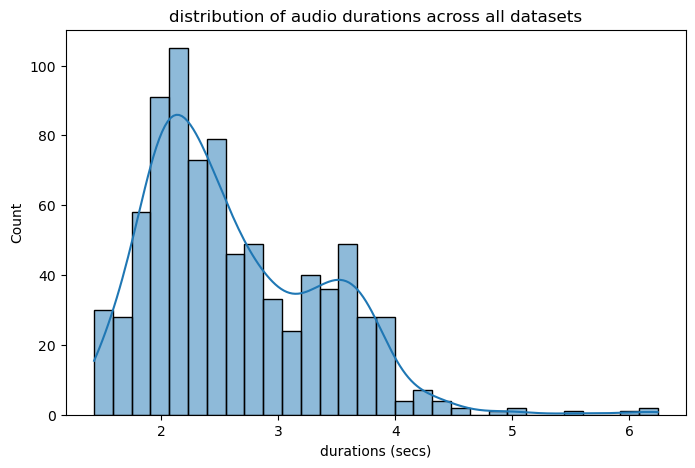

In [25]:
datasets = [ravdess, cremad, tess, savee]

k = 20
durations = []

def safe_load(path):
    path = Path(path)
    if not path.exists() or path.suffix.lower() != ".wav":
        return None, None
    if "__MACOSX" in str(path) or path.name.startswith("._"):
        return None, None
    y, sr = librosa.load(path, sr=None)
    return y, sr

for d in datasets:
    wav_files = list_wavs(d)
    sampled_wavs = wav_files[::k]  # sample every k-th file
    for wav in sampled_wavs:
        y, sr = safe_load(wav)
        if y is None:
            continue
        durations.append(len(y) / sr)

plt.figure(figsize=(8,5))
sns.histplot(durations, bins=30, kde=True)
plt.xlabel("durations (secs)")
plt.title("distribution of audio durations across all datasets")
plt.show()

In [39]:
import random

nums = 10 
cleaned_wavs = []
all_wavs = df["Path"].apply(Path).tolist()

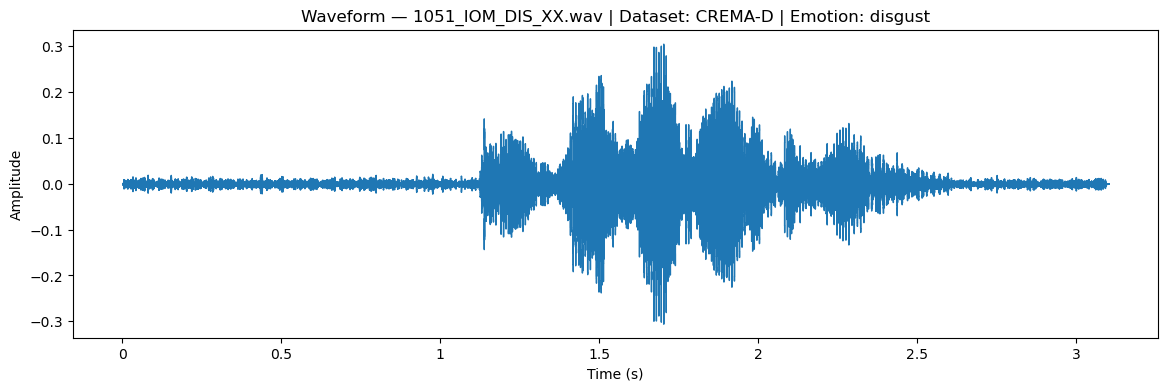

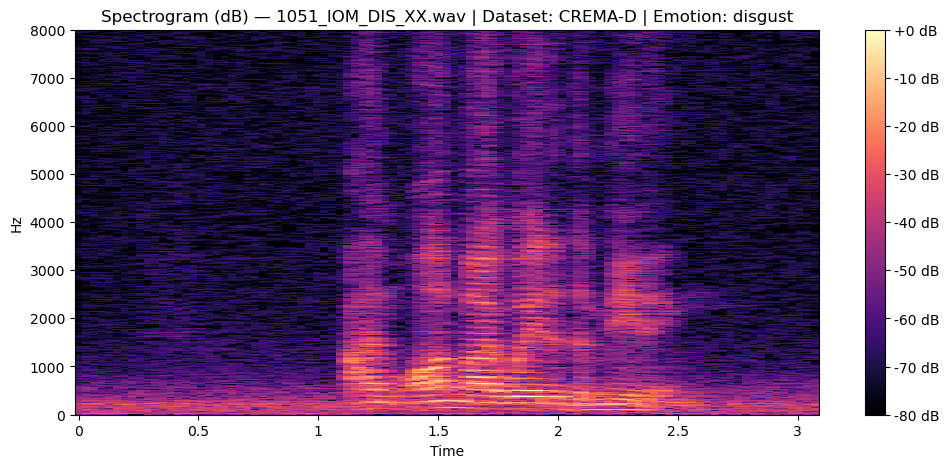

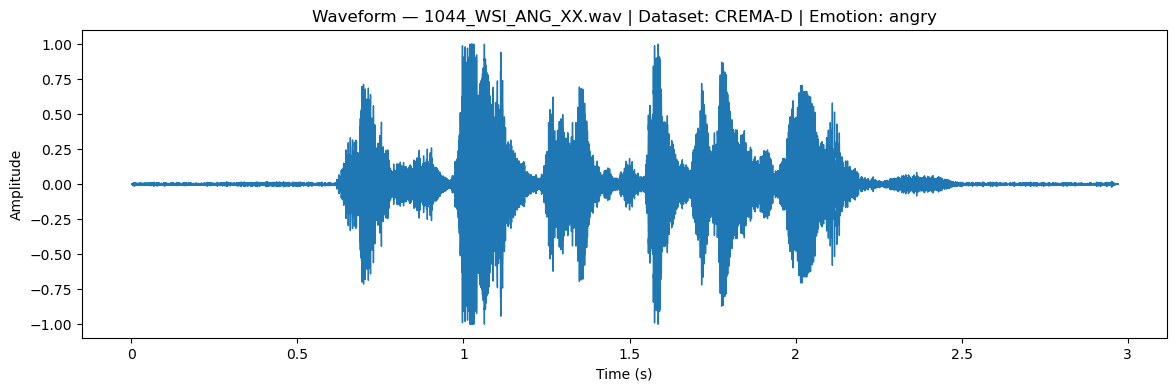

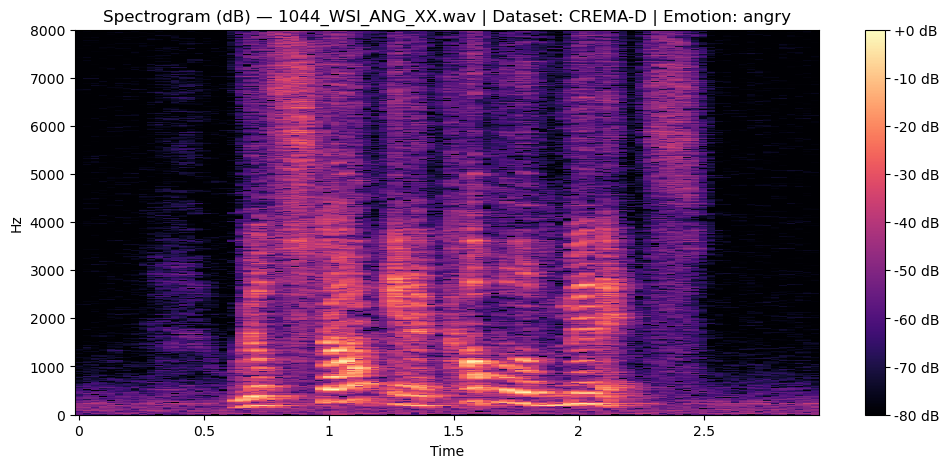

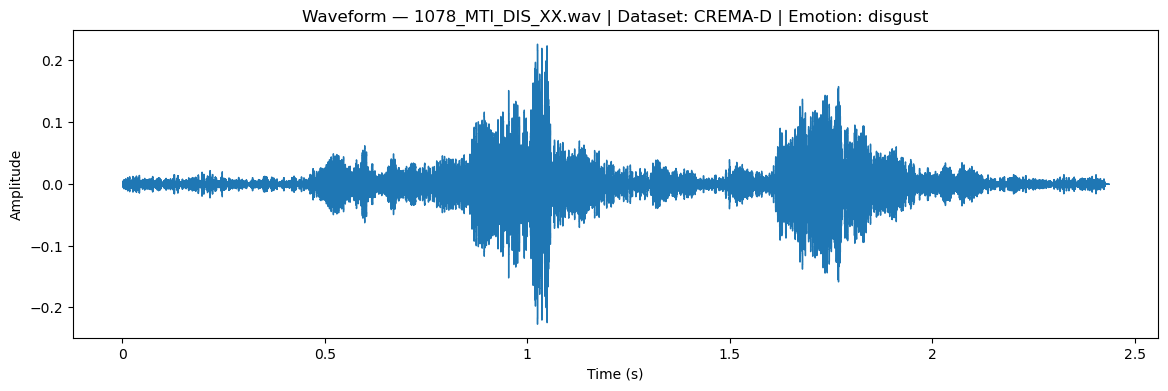

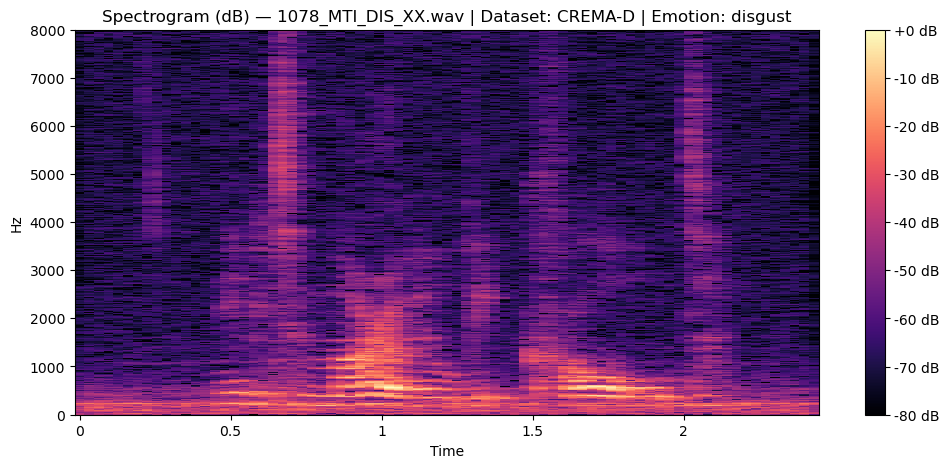

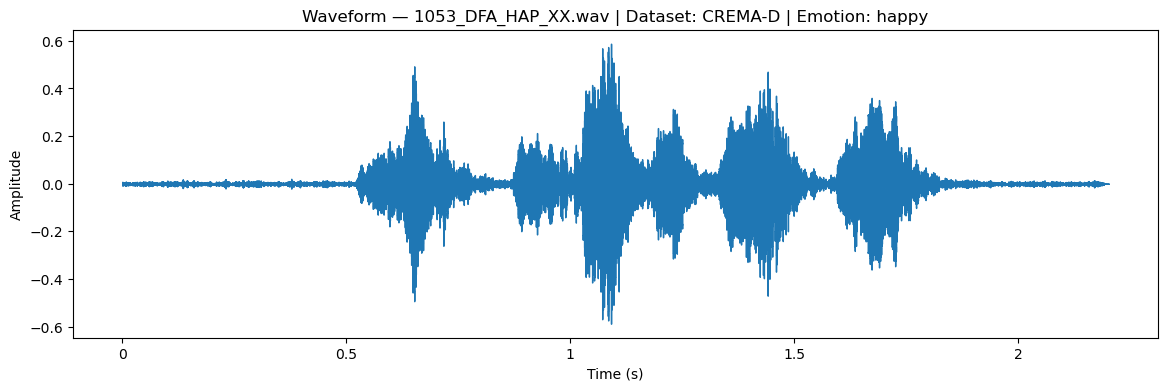

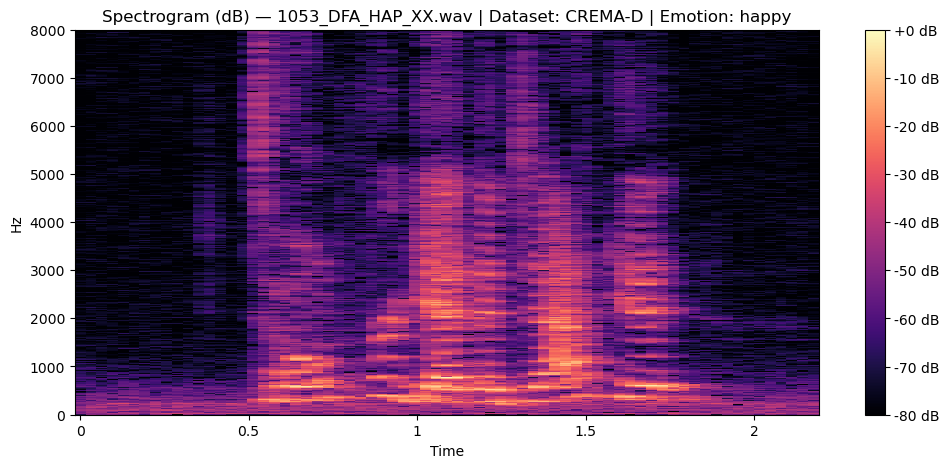

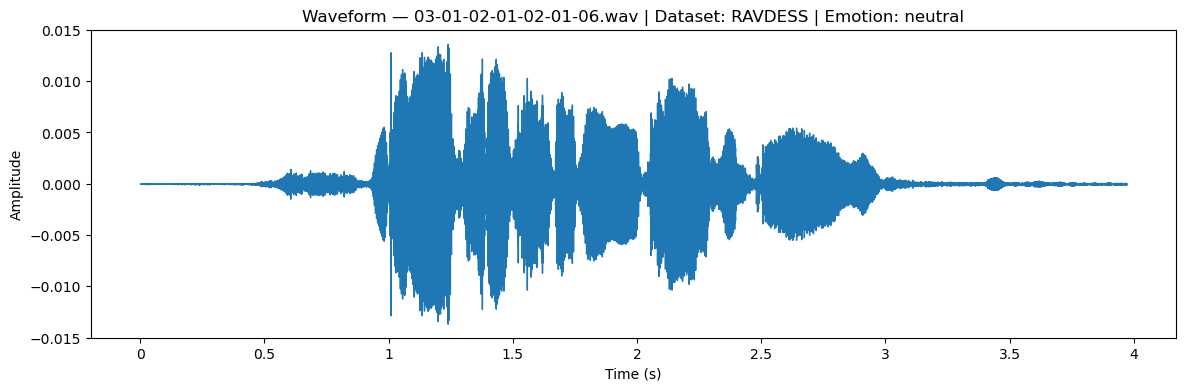

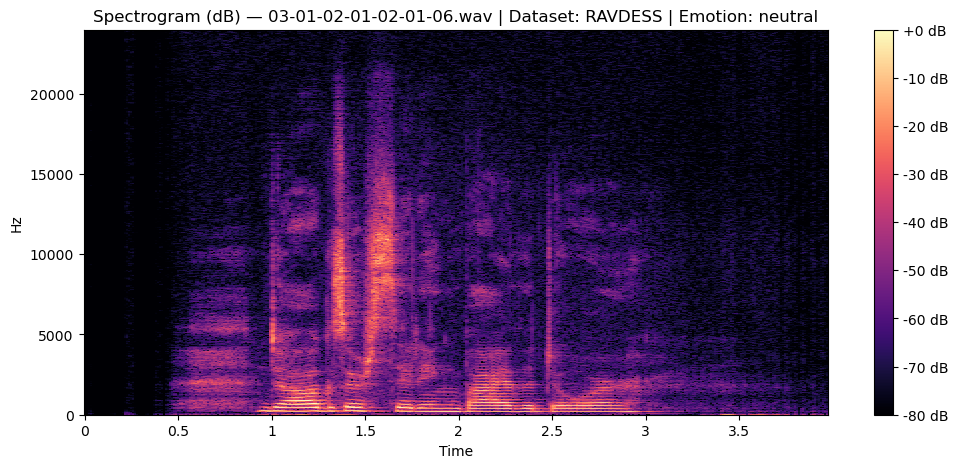

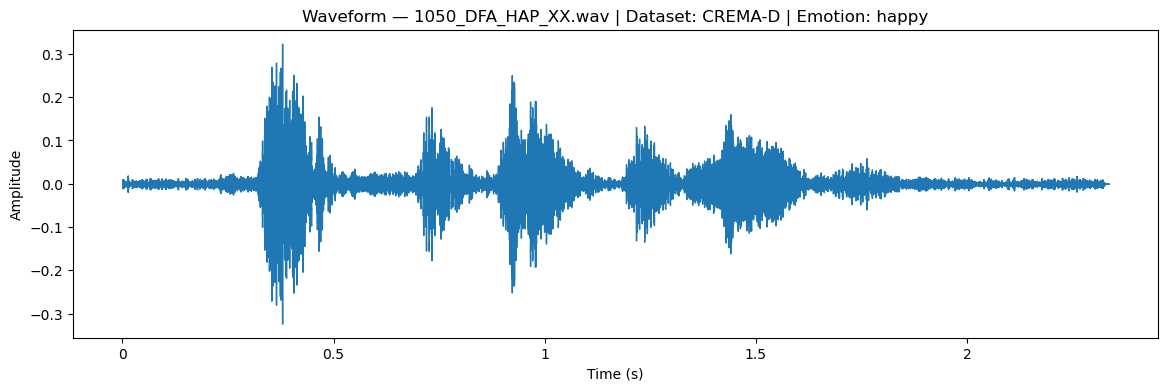

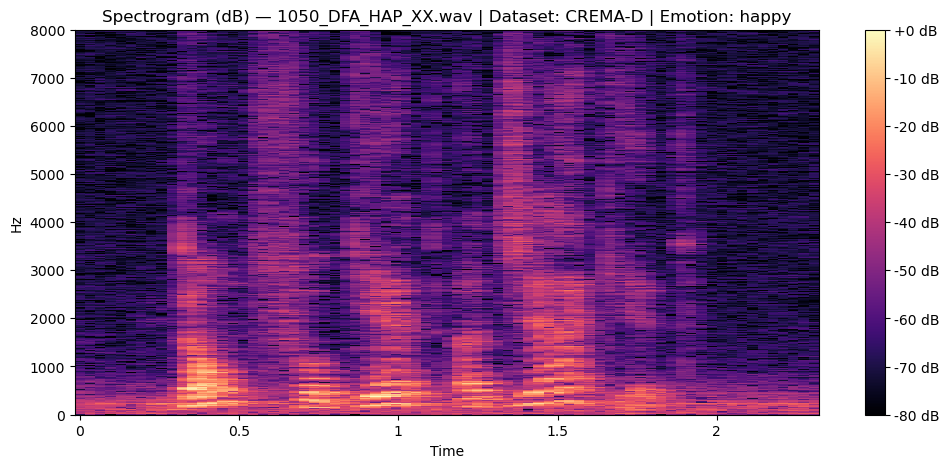

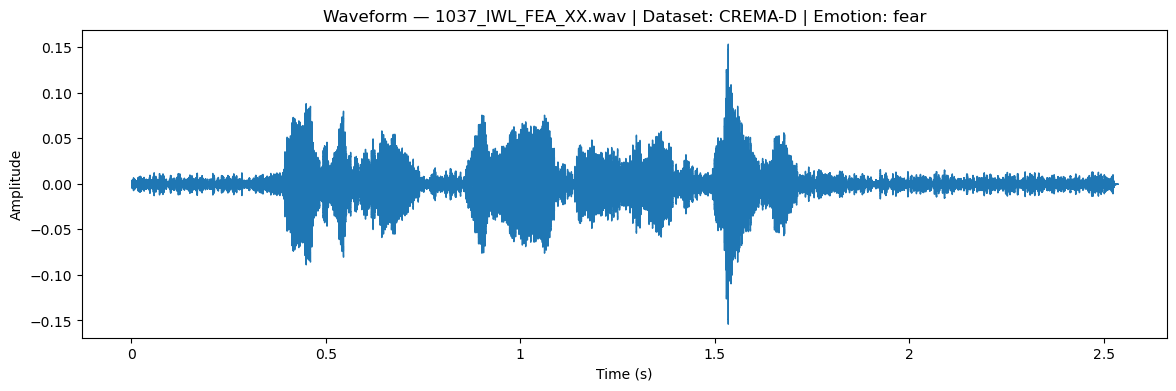

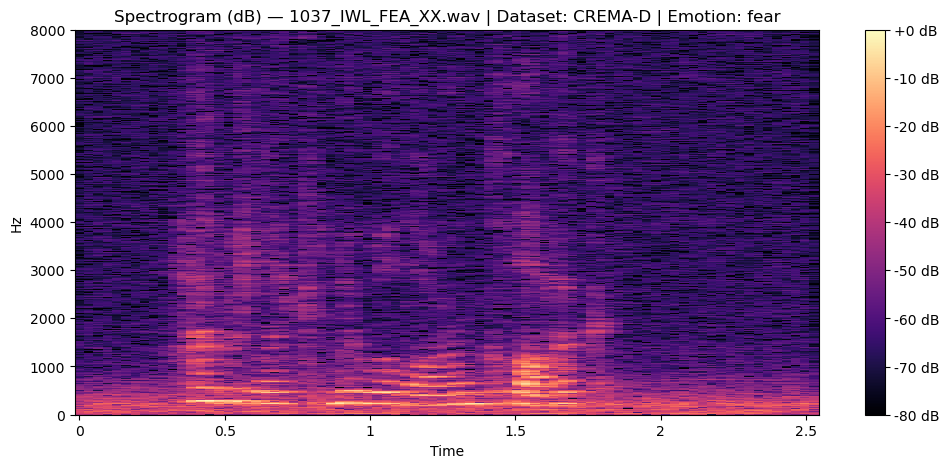

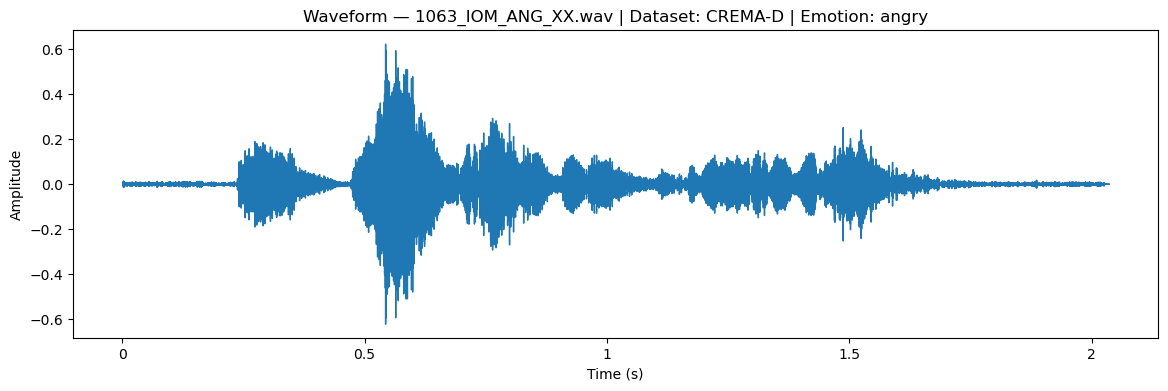

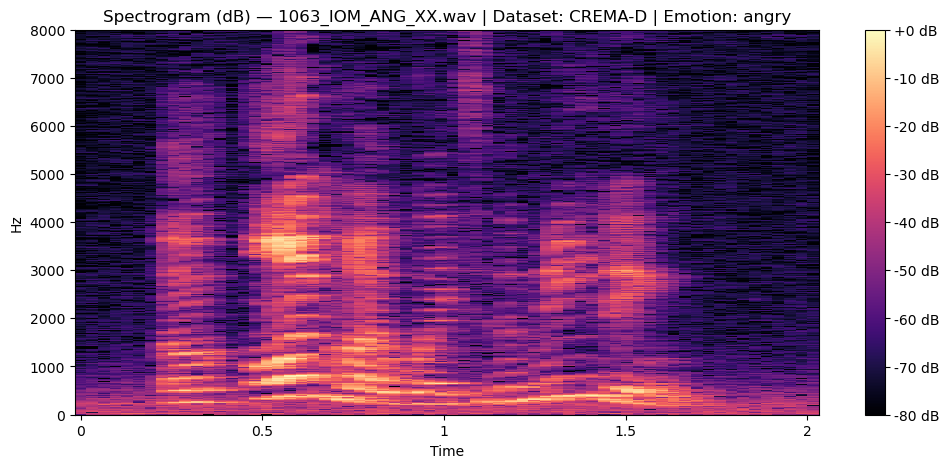

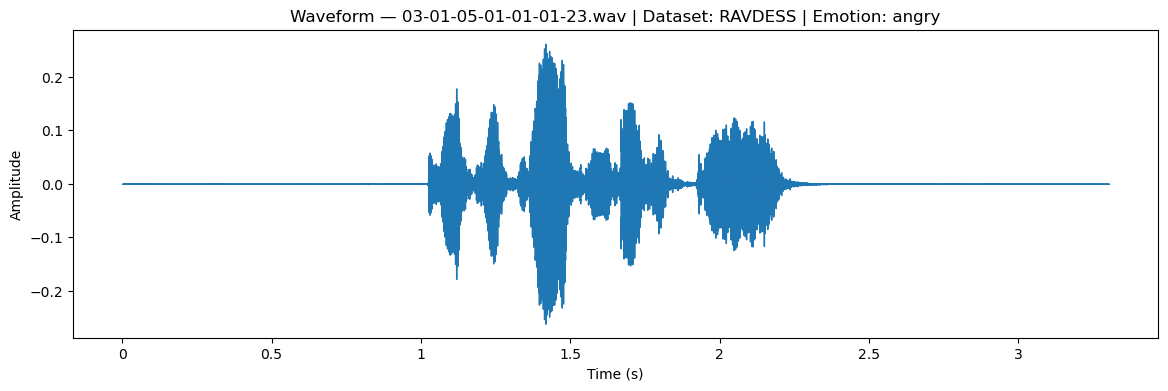

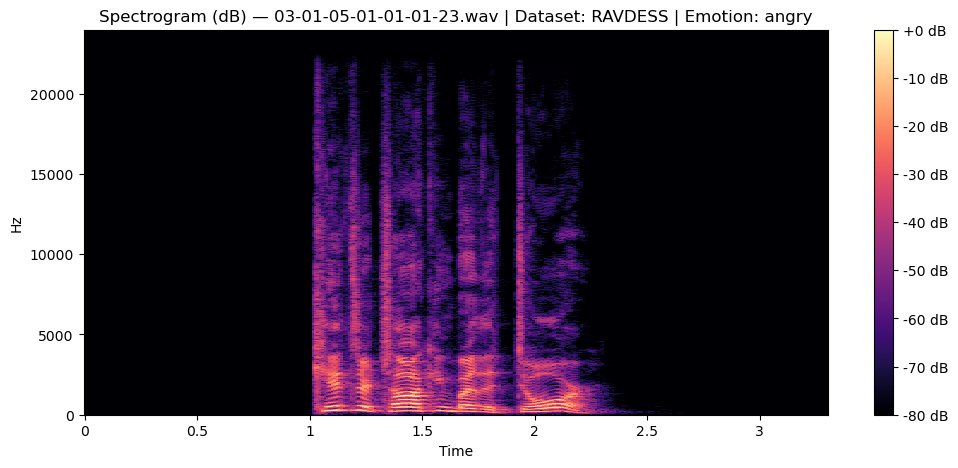

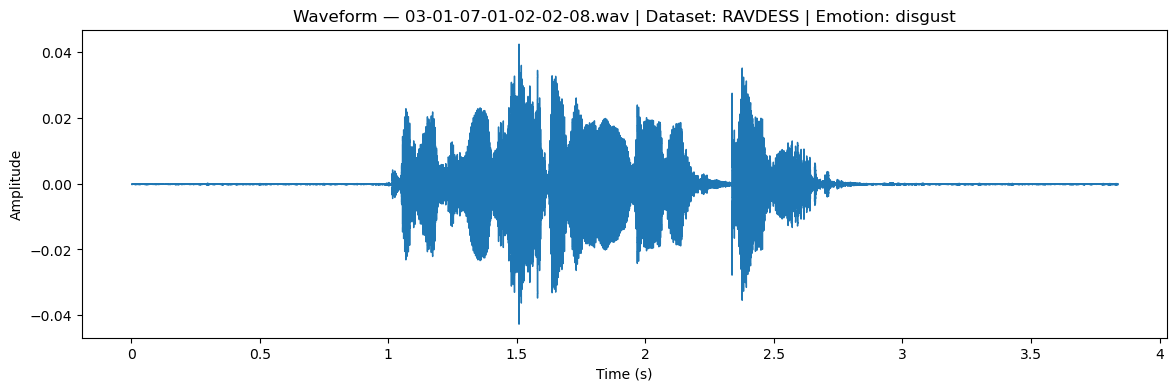

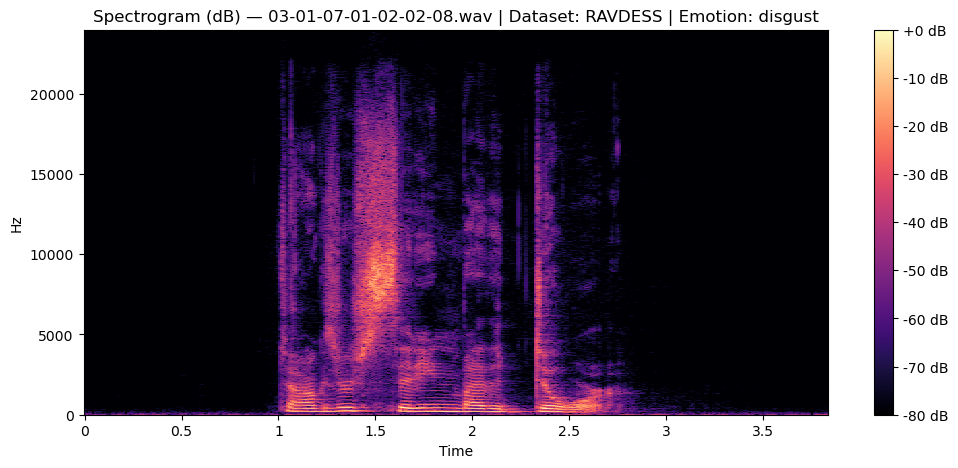

In [40]:
for wav in all_wavs:
    y, sr = safe_load(wav)
    if y is not None:
        cleaned_wavs.append(wav)

indices = random.sample(range(len(cleaned_wavs)), nums)

for i in indices:
    sample = cleaned_wavs[i]
    y, sr = librosa.load(sample, sr=None)
    
    # Get dataset and emotion info
    row = df[df["Path"] == str(sample)].iloc[0]
    dataset = row["dataset"]
    emotion = row["emotion_label"]
    
    # Waveform
    plt.figure(figsize=(14,4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform — {sample.name} | Dataset: {dataset} | Emotion: {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    
    # Spectrogram
    plt.figure(figsize=(12,5))
    spec = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.title(f"Spectrogram (dB) — {sample.name} | Dataset: {dataset} | Emotion: {emotion}")
    plt.colorbar(format="%+2.0f dB")
    plt.show()